In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# create modeling spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName('Project 2 plots')
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

# SettingWithCopyWarning problem might occur when changing order_datetime to date time, ignore this warning
pd.options.mode.chained_assignment = None

In [2]:
full_data = pd.read_parquet('../data/curated/clean_full_dataset')


In [3]:
transaction_df = full_data[['business_area_type', 'order_datetime']]

In [4]:
transaction_df['order_datetime']= pd.to_datetime(transaction_df['order_datetime'])

In [5]:
transaction_df['month'] = transaction_df['order_datetime'].dt.to_period('M')

In [6]:
# count number of transactions in each business area
business_transaction_count = transaction_df.groupby(['business_area_type',"month"]).count()

In [7]:
business_transaction_count

order_datetime
business_area_type           month                  
Arts and recreation services 2021-03             833
                             2021-04             814
                             2021-05             942
                             2021-06             939
                             2021-07             971
...                                              ...
Retail trade                 2022-04          496020
                             2022-05          559982
                             2022-06          553202
                             2022-07          581477
                             2022-08          529271

[108 rows x 1 columns]

In [8]:
# rename order datetime to Monthly count
business_transaction_count = business_transaction_count.rename(columns = {'order_datetime': 'Monthly Count'})

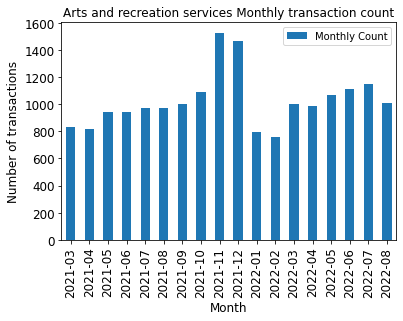

In [9]:
Arts = business_transaction_count.loc[["Arts and recreation services"]].reset_index(level=0, drop=True)

arts = Arts[['Monthly Count']].plot(kind='bar', \
                            title = "Arts and recreation services Monthly transaction count", fontsize=12)

arts.set_xlabel("Month", fontsize=12)
arts.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Arts_and_recreation_services_Monthly_transaction.png', bbox_inches='tight')

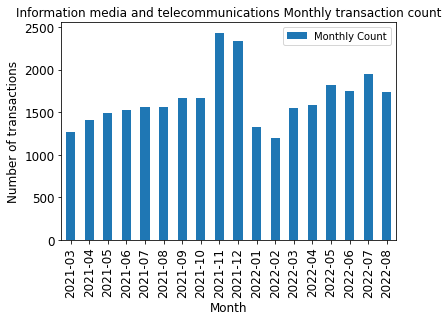

In [10]:
Info_teli = business_transaction_count.loc[["Information media and telecommunications"]]\
                .reset_index(level=0, drop=True)
info_teli = Info_teli[['Monthly Count']].plot(kind='bar', \
                title ="Information media and telecommunications Monthly transaction count", fontsize=12)
info_teli.set_xlabel("Month", fontsize=12)
info_teli.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Information_media_and_telecommunications_Monthly_transaction.png', 
            bbox_inches='tight')


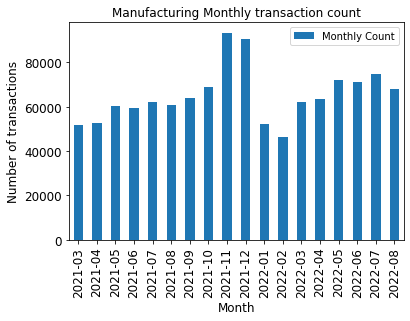

In [11]:
Manufacture = business_transaction_count.loc[["Manufacturing"]].reset_index(level=0, drop=True)
manufacture = Manufacture[['Monthly Count']].plot(kind='bar', \
                        title ="Manufacturing Monthly transaction count", fontsize=12)
manufacture.set_xlabel("Month", fontsize=12)
manufacture.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Manufacturing_Monthly_transaction.png', bbox_inches='tight')


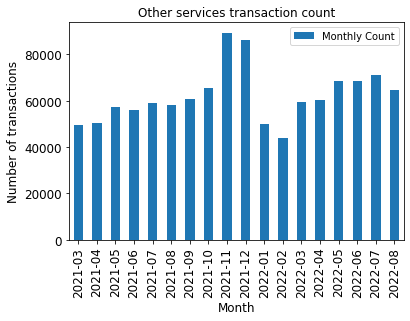

In [12]:
Other = business_transaction_count.loc[["Other services"]].reset_index(level=0, drop=True)
other = Other[['Monthly Count']].plot(kind='bar', title ="Other services transaction count", fontsize=12)
other.set_xlabel("Month", fontsize=12)
other.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Other_services_Monthly_transaction.png', bbox_inches='tight')


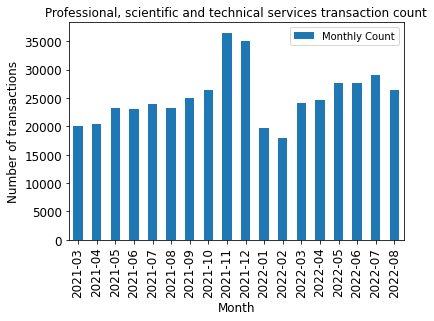

In [13]:
Professional = business_transaction_count.loc[["Professional, scientific and technical services"]]\
                .reset_index(level=0, drop=True)
pro_sci_tech = Professional[['Monthly Count']] \
    .plot(kind='bar', title ="Professional, scientific and technical services transaction count", fontsize=12)
pro_sci_tech.set_xlabel("Month", fontsize=12)
pro_sci_tech.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Professional_services_Monthly_transaction.png', bbox_inches='tight')


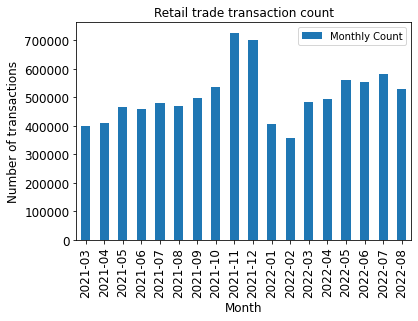

In [14]:
Retail = business_transaction_count.loc[["Retail trade"]].reset_index(level=0, drop=True)
retail = Retail[['Monthly Count']] \
    .plot(kind='bar', title ="Retail trade transaction count", fontsize=12)
retail.set_xlabel("Month", fontsize=12)
retail.set_ylabel("Number of transactions", fontsize=12)
plt.savefig("../plots/"+'Retail_Monthly_transaction.png', bbox_inches='tight')


### Plot ranking data, compare top 100 merchants and top 10 merchants in each business segment

In [16]:
top100 = spark.read.parquet('../data/curated/rank/ranking').limit(100)
top10fashion = spark.read.parquet('../data/curated/rank/fashion_rank').limit(10)
top10electric = spark.read.parquet('../data/curated/rank/electronic_rank').limit(10)
top10recreation = spark.read.parquet('../data/curated/rank/recreation_rank').limit(10)
top10household = spark.read.parquet('../data/curated/rank/household_rank').limit(10)

In [15]:
# set colors of the pie chart
colors = ['#e8e8e8','#52658f','#8aa0cf','#c5d5f8']

In [17]:
# Check BNPL revenue for top 100 merchants
top100.select(F.col("true_revenue")).toPandas().sum().round()

true_revenue    2205746.0
dtype: float64

In [18]:
top100_df = top100.select("revenue_level").groupby("revenue_level").count().toPandas()
top100_df

,revenue_level,count
0,a,50
1,b,39
2,c,11


### Plot top 100 for all merchants and top 10 for each business segment

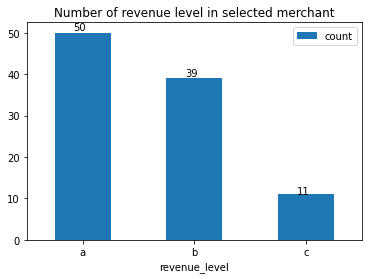

In [19]:
# top 100 merchant bar chart comparing revenue level
ax = top100_df.plot.bar(x = "revenue_level", rot=0, 
                        title='Number of revenue level in selected merchant')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/3, p.get_height()*1.01))
fig = ax.get_figure()
fig.savefig("../plots/Number of revenue level in selected merchant.png")

<Figure size 432x288 with 0 Axes>

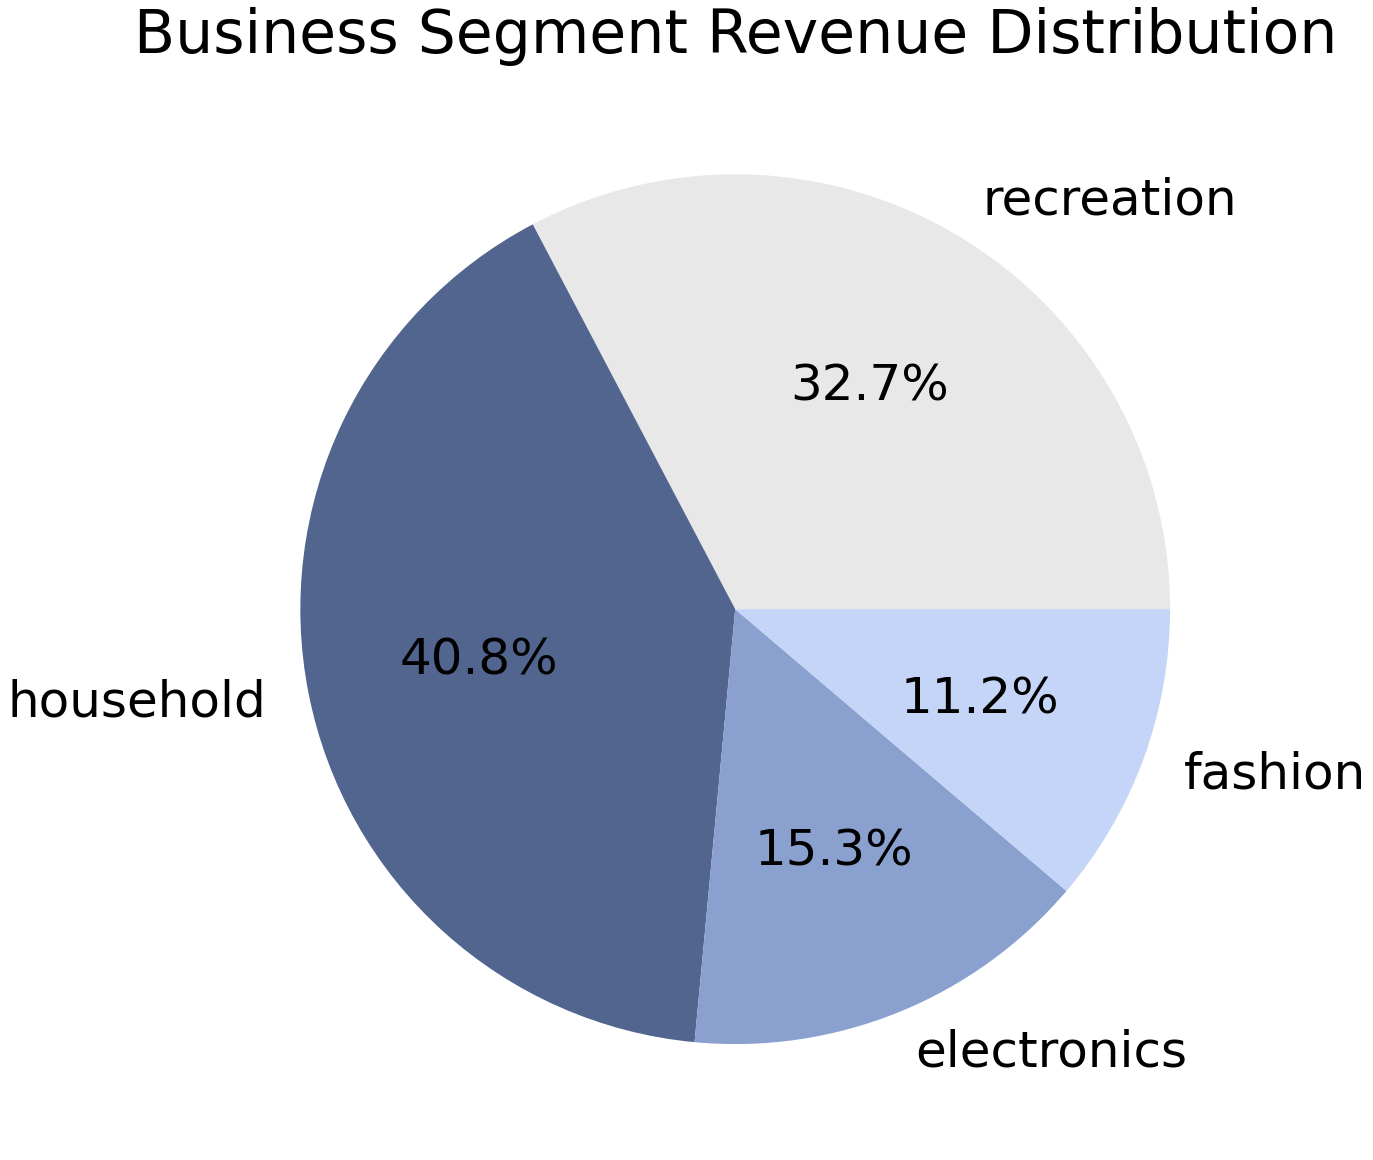

<Figure size 432x288 with 0 Axes>

In [20]:
# Top 100 merchant pie graph comparing revenue distribution based on business segment
top100_revenue_distribution = top100.select("business_segment", "true_revenue")\
                                                        .groupby("business_segment").sum().toPandas()
top100_revenue_distribution = top100_revenue_distribution.rename(columns={"sum(true_revenue)":"total revenue"})
top100_revenue_distribution = top100_revenue_distribution.set_index("business_segment")

ax = top100_revenue_distribution.plot.pie(y='total revenue', figsize=(20, 20), colors = colors, \
                                                           legend=False, autopct='%1.1f%%', \
                                                            shadow=False, fontsize = 50,  ylabel = "")

ax.set_title("Business Segment Revenue Distribution", fontdict={'fontsize':60})

plt.savefig("../plots/Business segment revenue distribution.png")
plt.figure()

<Figure size 432x288 with 0 Axes>

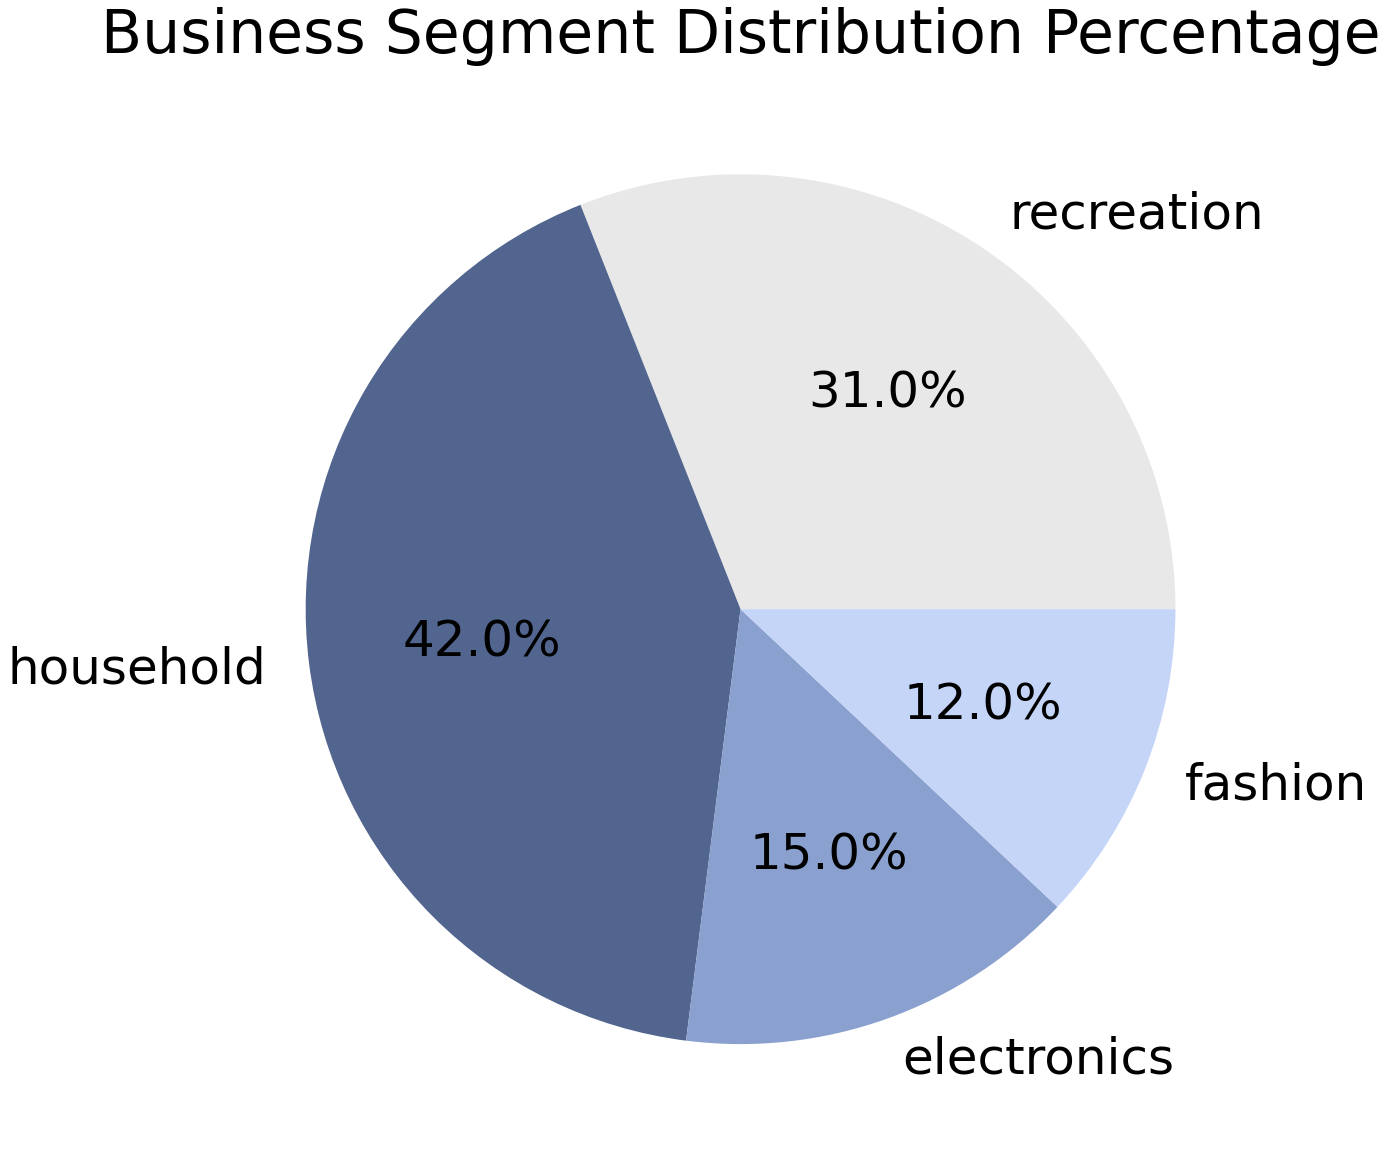

<Figure size 432x288 with 0 Axes>

In [21]:
# Top 100 merchant pie graph comparing business segment distribution 

top100_segment_distribution = top100.select("business_segment").groupby("business_segment").count().toPandas()
top100_segment_distribution = top100_segment_distribution.set_index("business_segment")
ax = top100_segment_distribution.plot.pie(y='count', \
                                        figsize=(20, 20), colors = colors, \
                                                           legend=False, autopct='%1.1f%%', \
                                                            shadow=False, fontsize = 50,  ylabel = "")

ax.set_title("Business Segment Distribution Percentage", fontdict={'fontsize':60})

plt.savefig("../plots/Business segment distribution.png")
plt.figure()




In [22]:
# Merge all top 10 dataset together, compare revenue distribution
top10_all_segment = top10fashion.union(top10electric)
top10_all_segment = top10_all_segment.union(top10recreation)
top10_all_segment = top10_all_segment.union(top10household)
top10_all_segment.select(F.col("true_revenue")).toPandas().sum().round()

true_revenue    1171057.0
dtype: float64

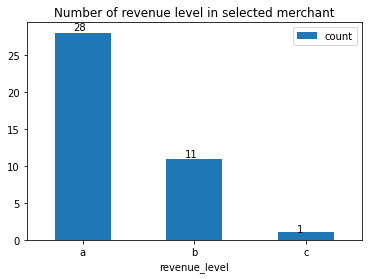

In [23]:
# compare revenue_level for top 10 merchant for 4 business segment

top10_all_segment_df = top10_all_segment.select("revenue_level").groupby("revenue_level")\
                        .count().orderBy("revenue_level").toPandas()

ax = top10_all_segment_df.plot.bar(x = "revenue_level", rot=0, 
                        title='Number of revenue level in selected merchant')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/3, p.get_height()*1.01))
fig = ax.get_figure()
fig.savefig("../plots/Number of revenue level in selected merchant(top 10).png")

<Figure size 432x288 with 0 Axes>

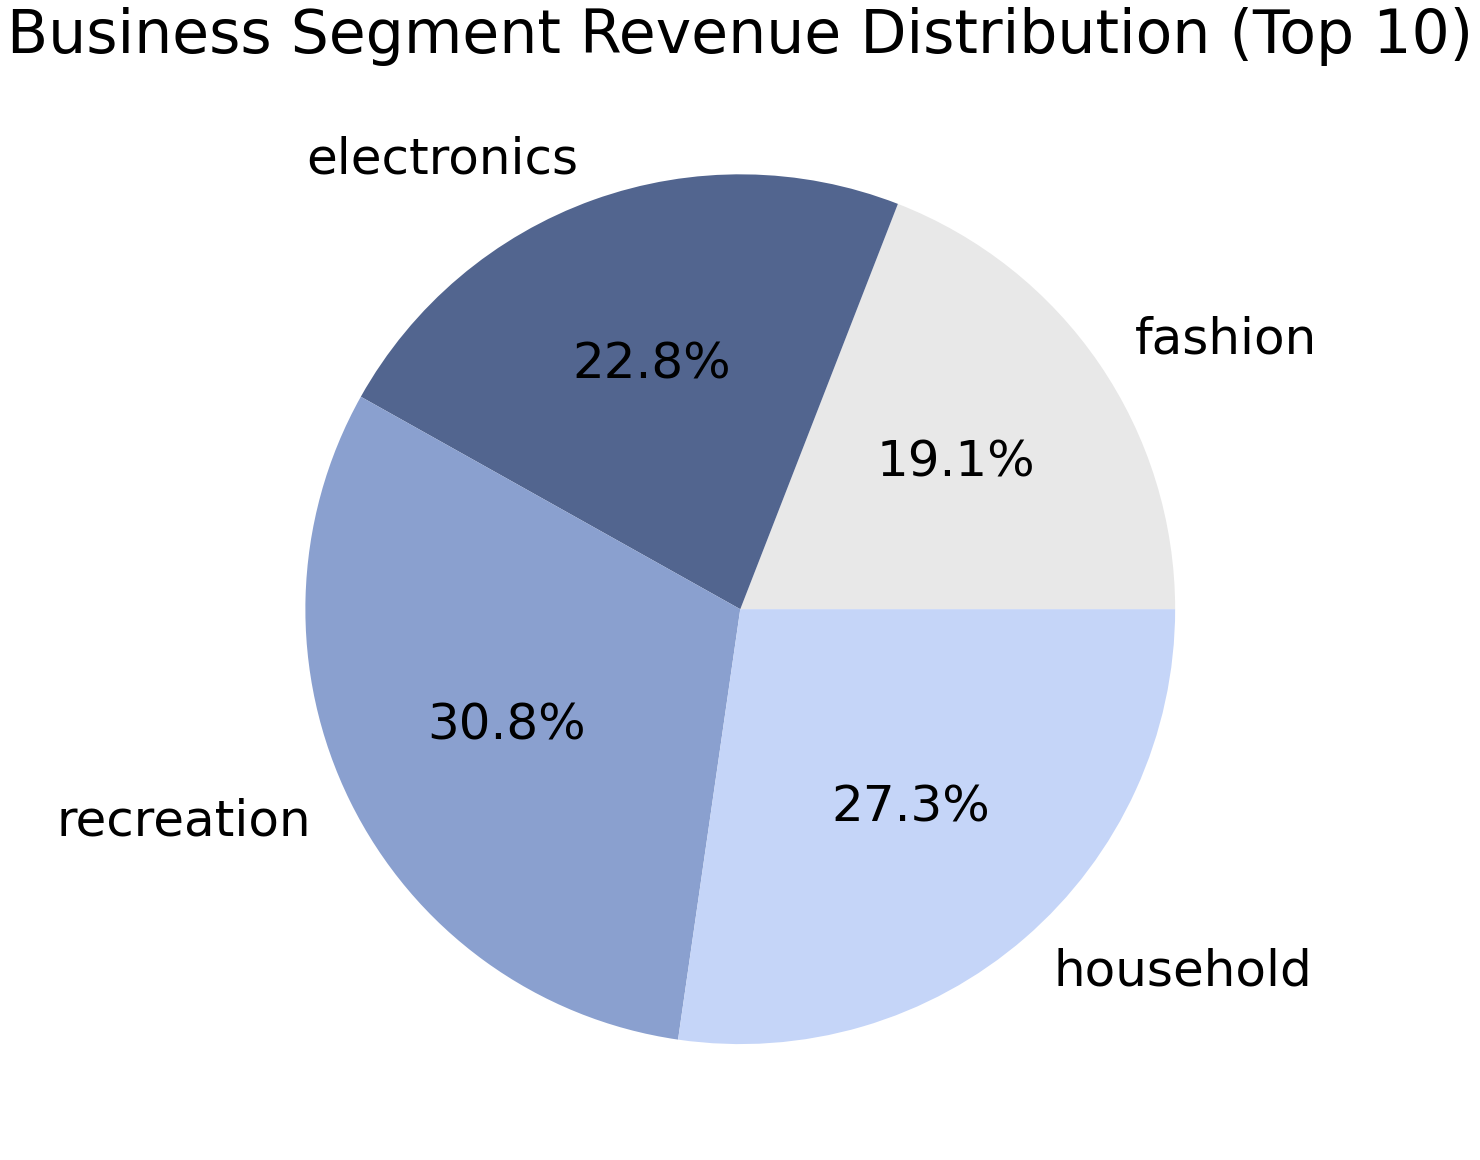

<Figure size 432x288 with 0 Axes>

In [25]:
# Compare revenue distribution for top 10 merchants in 4 business segment

top10_all_revenue_distribution = top10_all_segment.select("business_segment", "true_revenue")\
                                                        .groupby("business_segment").sum().toPandas()
top10_revenue_distribution = top10_all_revenue_distribution.rename(columns={"sum(true_revenue)":"total revenue"})
top10_revenue_distribution = top10_revenue_distribution.set_index("business_segment")

ax = top10_revenue_distribution.plot.pie(y='total revenue', figsize=(20, 20), colors = colors, \
                                                           legend=False, autopct='%1.1f%%', \
                                                            shadow=False, fontsize = 50,  ylabel = "")

ax.set_title("Business Segment Revenue Distribution (Top 10)", fontdict={'fontsize':60})

plt.savefig("../plots/Business segment revenue distribution(top 10).png")
plt.figure()